# NCAA March Madness 2025 - Descriptive Data Analysis

This notebook gives a first overview of the Kaggle raw data for men and women:
- table shapes and season coverage
- missing-value checks
- game volume by season
- score and margin distributions
- location and overtime behavior
- seed-based tournament patterns

In [21]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid', context='notebook')
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 140)

In [22]:
DATA_DIR = Path('../data/raw')

files = {
    'm_reg_compact': 'MRegularSeasonCompactResults.csv',
    'w_reg_compact': 'WRegularSeasonCompactResults.csv',
    'm_tour_compact': 'MNCAATourneyCompactResults.csv',
    'w_tour_compact': 'WNCAATourneyCompactResults.csv',
    'm_reg_detailed': 'MRegularSeasonDetailedResults.csv',
    'w_reg_detailed': 'WRegularSeasonDetailedResults.csv',
    'm_tour_detailed': 'MNCAATourneyDetailedResults.csv',
    'w_tour_detailed': 'WNCAATourneyDetailedResults.csv',
    'm_seeds': 'MNCAATourneySeeds.csv',
    'w_seeds': 'WNCAATourneySeeds.csv',
    'm_teams': 'MTeams.csv',
    'w_teams': 'WTeams.csv',
}

dfs = {k: pd.read_csv(DATA_DIR / v) for k, v in files.items()}

for k, df in dfs.items():
    print(f'{k:18s} -> {df.shape}')

m_reg_compact      -> (192930, 8)
w_reg_compact      -> (137028, 8)
m_tour_compact     -> (2518, 8)
w_tour_compact     -> (1650, 8)
m_reg_detailed     -> (118882, 34)
w_reg_detailed     -> (81708, 34)
m_tour_detailed    -> (1382, 34)
w_tour_detailed    -> (894, 34)
m_seeds            -> (2626, 3)
w_seeds            -> (1744, 3)
m_teams            -> (380, 4)
w_teams            -> (378, 2)


In [23]:
overview_rows = []
for name, df in dfs.items():
    row = {
        'dataset': name,
        'rows': len(df),
        'columns': df.shape[1],
        'min_season': df['Season'].min() if 'Season' in df.columns else np.nan,
        'max_season': df['Season'].max() if 'Season' in df.columns else np.nan,
        'unique_teams_in_games': np.nan,
    }
    if {'WTeamID', 'LTeamID'}.issubset(df.columns):
        row['unique_teams_in_games'] = pd.Index(df['WTeamID']).append(pd.Index(df['LTeamID'])).nunique()
    overview_rows.append(row)

overview = pd.DataFrame(overview_rows).sort_values('dataset').reset_index(drop=True)
overview

,dataset,rows,columns,min_season,max_season,unique_teams_in_games
0,m_reg_compact,192930,8,1985.0,2025.0,380.0
1,m_reg_detailed,118882,34,2003.0,2025.0,371.0
2,m_seeds,2626,3,1985.0,2025.0,NaN
3,m_teams,380,4,NaN,NaN,NaN
4,m_tour_compact,2518,8,1985.0,2024.0,309.0
5,m_tour_detailed,1382,34,2003.0,2024.0,268.0
6,w_reg_compact,137028,8,1998.0,2025.0,369.0
7,w_reg_detailed,81708,34,2010.0,2025.0,366.0
8,w_seeds,1744,3,1998.0,2025.0,NaN
9,w_teams,378,2,NaN,NaN,NaN


In [24]:
# Missing value rates (top 20 columns with highest null rate)
null_info = []
for name, df in dfs.items():
    miss = df.isna().mean().sort_values(ascending=False)
    miss = miss[miss > 0]
    for col, rate in miss.items():
        null_info.append({'dataset': name, 'column': col, 'missing_rate': rate})

null_df = pd.DataFrame(null_info)
if null_df.empty:
    print('No missing values found in the loaded datasets.')
else:
    display(null_df.sort_values('missing_rate', ascending=False).head(20))

No missing values found in the loaded datasets.


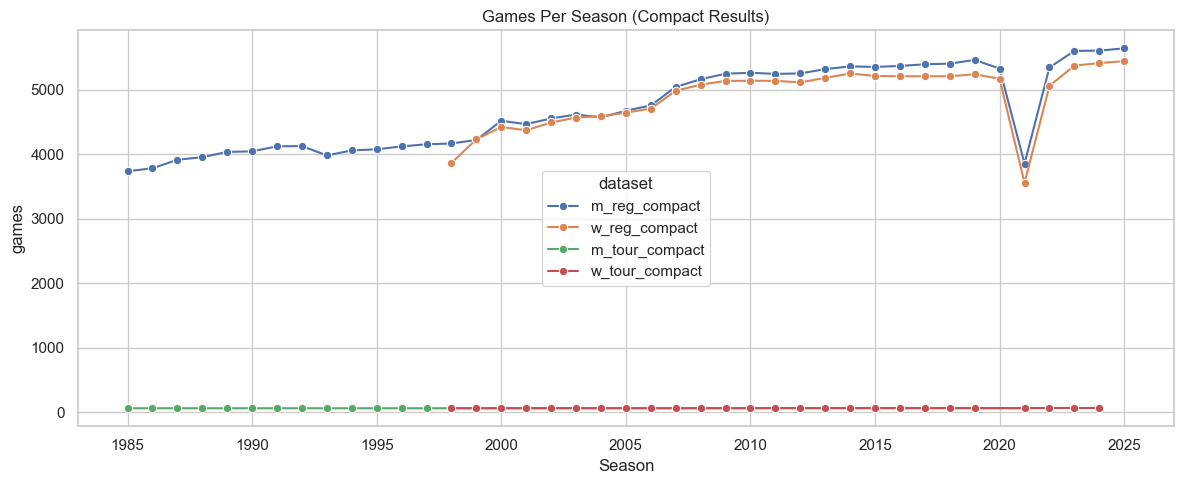

In [25]:
# Games per season for compact result files
season_counts = []
for label in ['m_reg_compact', 'w_reg_compact', 'm_tour_compact', 'w_tour_compact']:
    tmp = dfs[label].groupby('Season').size().rename('games').reset_index()
    tmp['dataset'] = label
    season_counts.append(tmp)
season_counts = pd.concat(season_counts, ignore_index=True)

plt.figure(figsize=(12, 5))
sns.lineplot(data=season_counts, x='Season', y='games', hue='dataset', marker='o')
plt.title('Games Per Season (Compact Results)')
plt.tight_layout()
plt.show()

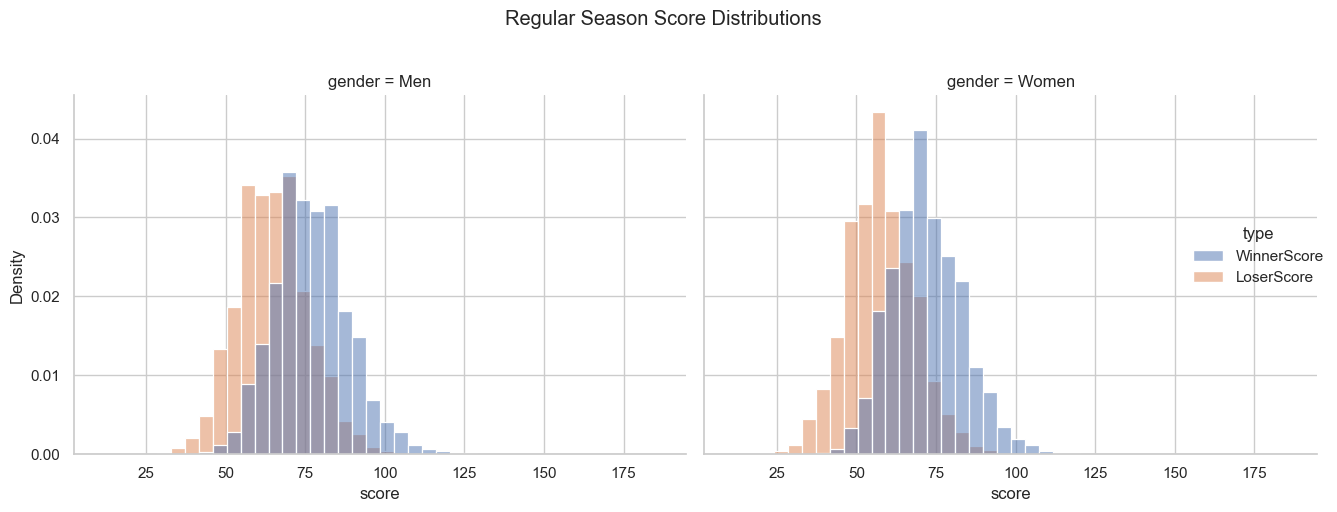

In [31]:
# Winner vs loser score distributions in regular season
score_rows = []
for label, gender in [('m_reg_compact', 'Men'), ('w_reg_compact', 'Women')]:
    df = dfs[label]
    score_rows.append(pd.DataFrame({'gender': gender, 'type': 'WinnerScore', 'score': df['WScore']}))
    score_rows.append(pd.DataFrame({'gender': gender, 'type': 'LoserScore', 'score': df['LScore']}))
score_df = pd.concat(score_rows, ignore_index=True)

sns.displot(data=score_df, x='score', hue='type', col='gender', bins=40, stat='density', common_norm=False, height=5, aspect=1.2)
plt.suptitle('Regular Season Score Distributions', y=1.02)
plt.tight_layout()
plt.show()


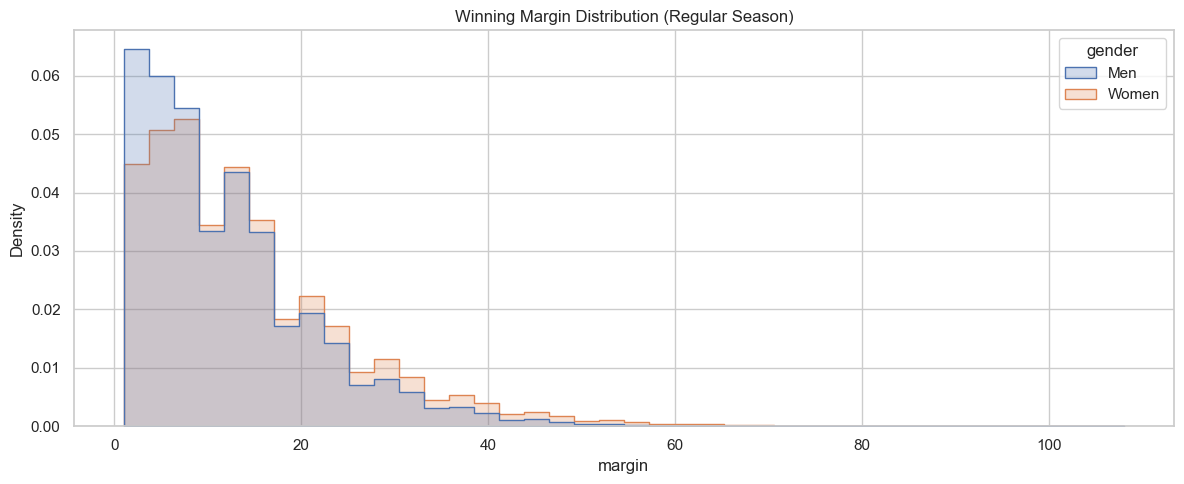

,count,mean,std,min,25%,50%,75%,max
gender,,,,,,,,
Men,192930.0,12.08,9.39,1.0,5.0,10.0,17.0,94.0
Women,137028.0,14.39,10.99,1.0,6.0,12.0,19.0,108.0


In [27]:
# Winning margin distributions
margin_rows = []
for label, gender in [('m_reg_compact', 'Men'), ('w_reg_compact', 'Women')]:
    df = dfs[label].copy()
    df['margin'] = df['WScore'] - df['LScore']
    margin_rows.append(pd.DataFrame({'gender': gender, 'margin': df['margin']}))
margin_df = pd.concat(margin_rows, ignore_index=True)

plt.figure(figsize=(12, 5))
sns.histplot(data=margin_df, x='margin', hue='gender', bins=40, element='step', stat='density', common_norm=False)
plt.title('Winning Margin Distribution (Regular Season)')
plt.tight_layout()
plt.show()

margin_df.groupby('gender')['margin'].describe().round(2)

C:\Users\Kenny\AppData\Local\Temp\ipykernel_26028\246804443.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=loc_df, x='WLoc', y='pct', hue='stage', ci=None)


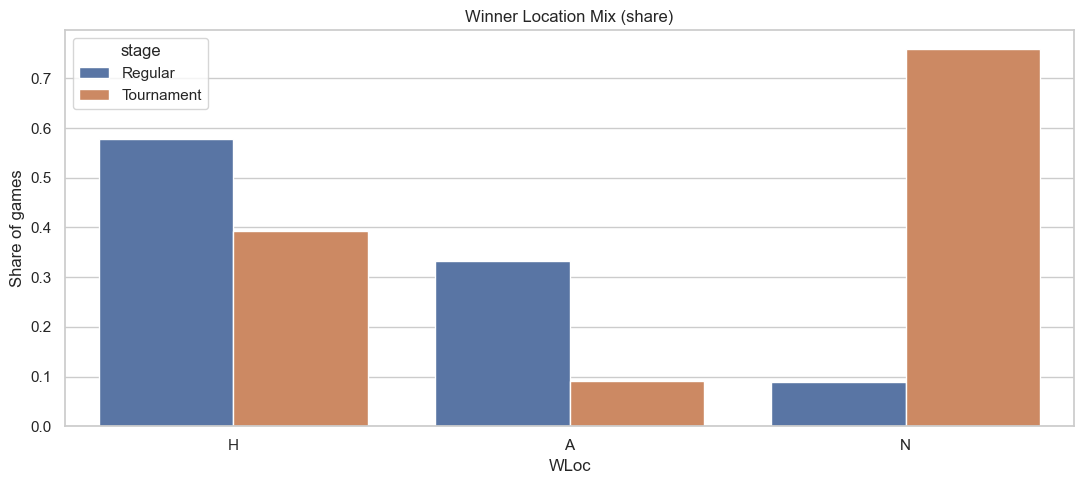

,WLoc,pct,gender,stage
1,A,0.307091,Men,Regular
0,H,0.590484,Men,Regular
2,N,0.102426,Men,Regular
6,N,1.000000,Men,Tournament
4,A,0.359233,Women,Regular
3,H,0.566257,Women,Regular
5,N,0.074510,Women,Regular
9,A,0.090303,Women,Tournament
8,H,0.392727,Women,Tournament
7,N,0.516970,Women,Tournament


In [28]:
# Home/Away/Neutral distribution
loc_rows = []
for label, gender, stage in [
    ('m_reg_compact', 'Men', 'Regular'),
    ('w_reg_compact', 'Women', 'Regular'),
    ('m_tour_compact', 'Men', 'Tournament'),
    ('w_tour_compact', 'Women', 'Tournament'),
]:
    df = dfs[label]
    counts = df['WLoc'].value_counts(normalize=True).rename_axis('WLoc').reset_index(name='pct')
    counts['gender'] = gender
    counts['stage'] = stage
    loc_rows.append(counts)
loc_df = pd.concat(loc_rows, ignore_index=True)

plt.figure(figsize=(11, 5))
sns.barplot(data=loc_df, x='WLoc', y='pct', hue='stage', ci=None)
plt.title('Winner Location Mix (share)')
plt.ylabel('Share of games')
plt.tight_layout()
plt.show()

loc_df.sort_values(['gender', 'stage', 'WLoc'])

C:\Users\Kenny\AppData\Local\Temp\ipykernel_26028\2214163682.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=ot_df[ot_df['NumOT'] <= 3], x='NumOT', y='pct', hue='stage', ci=None)


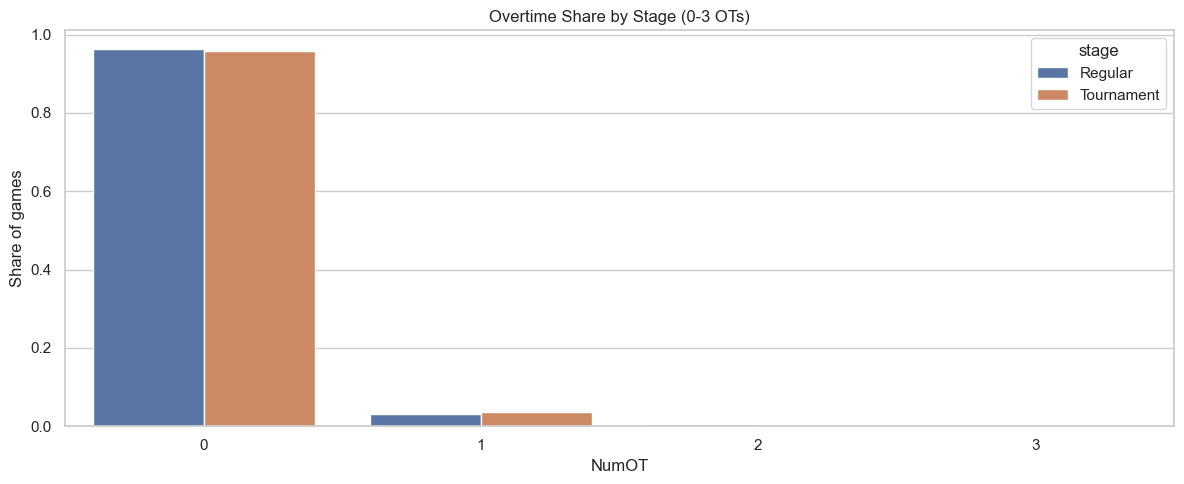

,NumOT,pct,gender,stage
0,0,0.959327,Men,Regular
1,1,0.033852,Men,Regular
2,2,0.005536,Men,Regular
3,3,0.001037,Men,Regular
4,4,0.000218,Men,Regular
5,5,0.000026,Men,Regular
6,6,0.000005,Men,Regular
13,0,0.940429,Men,Tournament
14,1,0.052820,Men,Tournament
15,2,0.006354,Men,Tournament


In [29]:
# Overtime frequencies
ot_rows = []
for label, gender, stage in [
    ('m_reg_compact', 'Men', 'Regular'),
    ('w_reg_compact', 'Women', 'Regular'),
    ('m_tour_compact', 'Men', 'Tournament'),
    ('w_tour_compact', 'Women', 'Tournament'),
]:
    df = dfs[label]
    counts = df['NumOT'].value_counts(normalize=True).sort_index().reset_index()
    counts.columns = ['NumOT', 'pct']
    counts['gender'] = gender
    counts['stage'] = stage
    ot_rows.append(counts)
ot_df = pd.concat(ot_rows, ignore_index=True)

plt.figure(figsize=(12, 5))
sns.barplot(data=ot_df[ot_df['NumOT'] <= 3], x='NumOT', y='pct', hue='stage', ci=None)
plt.title('Overtime Share by Stage (0-3 OTs)')
plt.ylabel('Share of games')
plt.tight_layout()
plt.show()

ot_df.sort_values(['gender', 'stage', 'NumOT']).head(20)

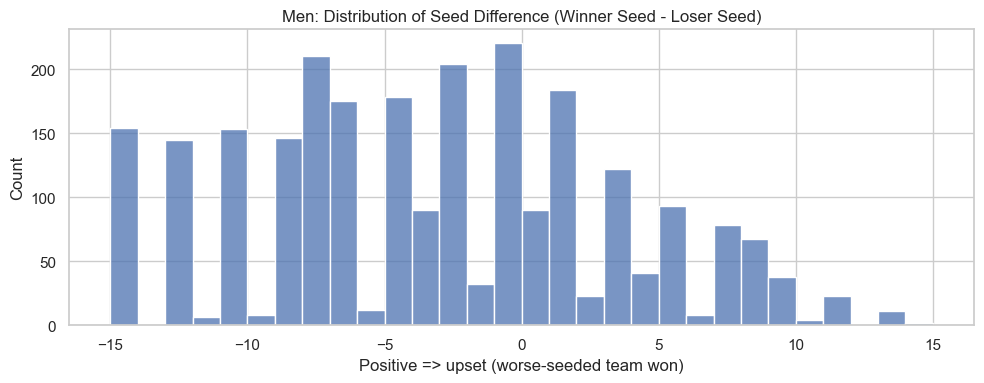

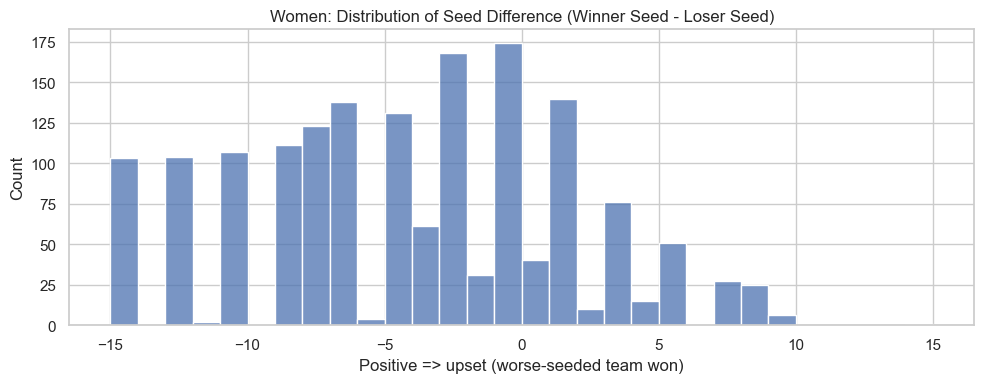

,gender,games,upset_rate
0,Men,2518,0.276013
1,Women,1650,0.213333


In [30]:
def parse_seed(seed):
    m = re.search(r'(\d+)', str(seed))
    return int(m.group(1)) if m else np.nan

seed_summaries = []
for seed_key, game_key, gender in [
    ('m_seeds', 'm_tour_compact', 'Men'),
    ('w_seeds', 'w_tour_compact', 'Women'),
]:
    seeds = dfs[seed_key].copy()
    games = dfs[game_key].copy()

    seeds['SeedNum'] = seeds['Seed'].map(parse_seed)
    seeds_w = seeds[['Season', 'TeamID', 'SeedNum']].rename(columns={'TeamID': 'WTeamID', 'SeedNum': 'WSeedNum'})
    seeds_l = seeds[['Season', 'TeamID', 'SeedNum']].rename(columns={'TeamID': 'LTeamID', 'SeedNum': 'LSeedNum'})

    merged = games.merge(seeds_w, on=['Season', 'WTeamID'], how='left').merge(seeds_l, on=['Season', 'LTeamID'], how='left')
    merged['seed_diff_w_minus_l'] = merged['WSeedNum'] - merged['LSeedNum']
    merged['is_upset_win'] = merged['seed_diff_w_minus_l'] > 0
    merged['gender'] = gender

    upset_rate = merged['is_upset_win'].mean()
    seed_summaries.append({'gender': gender, 'games': len(merged), 'upset_rate': upset_rate})

    plt.figure(figsize=(10, 4))
    sns.histplot(merged['seed_diff_w_minus_l'].dropna(), bins=30)
    plt.title(f'{gender}: Distribution of Seed Difference (Winner Seed - Loser Seed)')
    plt.xlabel('Positive => upset (worse-seeded team won)')
    plt.tight_layout()
    plt.show()

pd.DataFrame(seed_summaries)

## Notes / Next Steps

Typical next steps after this EDA:
1. Build team-season aggregate features from regular season games.
2. Merge tournament seeds and optional rankings.
3. Create pairwise training examples from tournament matchups.
4. Train a first baseline model (e.g., logistic regression or gradient boosting).